In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tabulate import tabulate
import time
import numpy as np

In [4]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


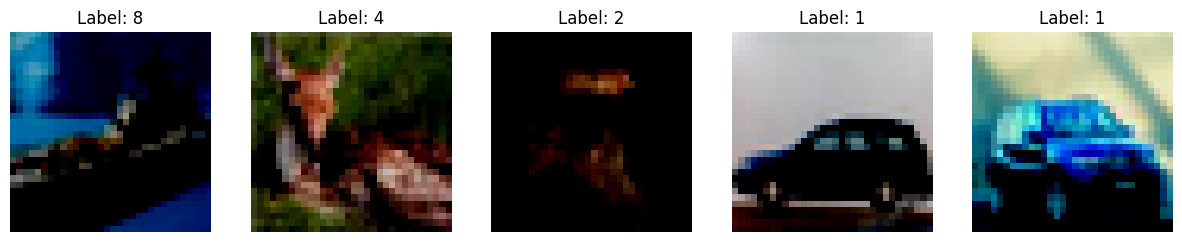

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


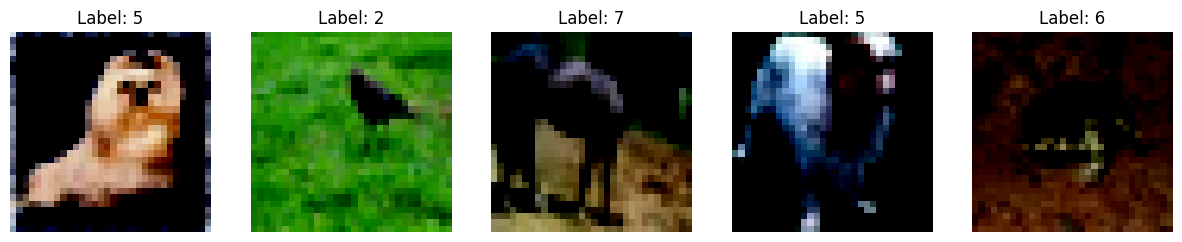

In [6]:
import random

# Function to display random images with labels from the dataset
def display_random_images_with_labels(dataset, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        index = random.randint(0, len(dataset) - 1)
        image, label = dataset[index]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.show()

# Display random images with labels from the training dataset
display_random_images_with_labels(train_dataset)

# Display random images with labels from the test dataset
display_random_images_with_labels(test_dataset)

In [7]:
# Split train dataset into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [8]:
# Display sizes of train, test, and validation sets
print(f"Size of the training set: {len(train_dataset)}")
print(f"Size of the validation set: {len(val_dataset)}")
print(f"Size of the test set: {len(test_dataset)}")

Size of the training set: 40000
Size of the validation set: 10000
Size of the test set: 10000


In [9]:
# Move data loaders to GPU if available
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

In [10]:
def train(model, criterion, optimizer, train_loader, val_loader, num_epochs=100):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        start_time = time.time()  # Record start time for the epoch

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            predicted_probs = torch.softmax(outputs, 1)
            _, predicted = torch.max(predicted_probs, 1)  # Get the predicted class labels
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct_train / total_train

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to GPU
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                predicted_probs = torch.softmax(outputs, 1)
                _, predicted = torch.max(predicted_probs, 1)  # Get the predicted class labels
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = correct_val / total_val

        end_time = time.time()  # Record end time for the epoch
        epoch_time = end_time - start_time  # Calculate epoch time

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Time: {epoch_time:.2f} seconds")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs

In [11]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to GPU
            outputs = model(inputs)
            predicted = torch.argmax(torch.softmax(outputs, 1), dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = correct / total
    return test_accuracy

### Variant 4:

In [12]:
from torch.nn.functional import avg_pool2d  # Import avg_pool2d from torch.nn.functional

class MiniVGG_with_global_avg_pool(nn.Module):
    def __init__(self):
        super(MiniVGG_with_global_avg_pool, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.maxpool3 = nn.MaxPool2d(2, 2)
        self.conv7 = nn.Conv2d(256, 128, 1)  # Add convolution layer (1x1) x 128
        self.conv8 = nn.Conv2d(128, 10, 1)   # Add convolution layer (1x1) x 10

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.maxpool1(x)
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = self.maxpool2(x)
        x = torch.relu(self.conv5(x))
        x = torch.relu(self.conv6(x))
        x = self.maxpool3(x)
        x = torch.relu(self.conv7(x))  # Apply convolution (1x1) x 128
        x = torch.relu(self.conv8(x))  # Apply convolution (1x1) x 10
        x = avg_pool2d(x, x.size()[2:])  # Global Average Pooling using avg_pool2d from torch.nn.functional
        x = x.view(-1, 10)  # Reshape to (batch_size, num_classes)
        return x

In [13]:
# Define table headers and data
headers = ["Layer Type", "Window Size", "Number of Filters"]
data = [
    ["Convolutional", "(3x3)", "64"],
    ["Convolutional", "(3x3)", "64"],
    ["MaxPool", "(2x2)", "-"],
    ["Convolutional", "(3x3)", "128"],
    ["Convolutional", "(3x3)", "128"],
    ["MaxPool", "(2x2)", "-"],
    ["Convolutional", "(3x3)", "256"],
    ["Convolutional", "(3x3)", "256"],
    ["MaxPool", "(2x2)", "-"],
    ["Convolutional", "(1x1)", "128"],  # Change from Fully Connected to Convolutional
    ["Convolutional", "(1x1)", "10"],   # Change from Fully Connected to Convolutional
]

# Display table
print(tabulate(data, headers=headers, tablefmt="grid"))

+---------------+---------------+---------------------+
| Layer Type    | Window Size   | Number of Filters   |
+===============+===============+=====================+
| Convolutional | (3x3)         | 64                  |
+---------------+---------------+---------------------+
| Convolutional | (3x3)         | 64                  |
+---------------+---------------+---------------------+
| MaxPool       | (2x2)         | -                   |
+---------------+---------------+---------------------+
| Convolutional | (3x3)         | 128                 |
+---------------+---------------+---------------------+
| Convolutional | (3x3)         | 128                 |
+---------------+---------------+---------------------+
| MaxPool       | (2x2)         | -                   |
+---------------+---------------+---------------------+
| Convolutional | (3x3)         | 256                 |
+---------------+---------------+---------------------+
| Convolutional | (3x3)         | 256           

In [12]:
# Move MiniVGG_with_global_avg_pool model to GPU if available
model = MiniVGG_with_global_avg_pool().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train MiniVGG_with_global_avg_pool model on GPU
train_losses, val_losses, train_accs, val_accs = train(model, criterion, optimizer, train_loader, val_loader, num_epochs=70)

Epoch 1/70, Train Loss: 2.0827, Val Loss: 1.9494, Train Acc: 0.2627, Val Acc: 0.3333, Time: 2.76 seconds
Epoch 2/70, Train Loss: 1.7466, Val Loss: 1.5805, Train Acc: 0.4178, Val Acc: 0.4816, Time: 2.39 seconds
Epoch 3/70, Train Loss: 1.5370, Val Loss: 1.4675, Train Acc: 0.4964, Val Acc: 0.5221, Time: 2.42 seconds
Epoch 4/70, Train Loss: 1.4321, Val Loss: 1.4251, Train Acc: 0.5298, Val Acc: 0.5320, Time: 2.38 seconds
Epoch 5/70, Train Loss: 1.3583, Val Loss: 1.3705, Train Acc: 0.5540, Val Acc: 0.5483, Time: 2.39 seconds
Epoch 6/70, Train Loss: 1.2991, Val Loss: 1.3554, Train Acc: 0.5696, Val Acc: 0.5509, Time: 2.40 seconds
Epoch 7/70, Train Loss: 1.2439, Val Loss: 1.2824, Train Acc: 0.5847, Val Acc: 0.5718, Time: 2.40 seconds
Epoch 8/70, Train Loss: 1.1961, Val Loss: 1.2735, Train Acc: 0.5982, Val Acc: 0.5776, Time: 2.40 seconds
Epoch 9/70, Train Loss: 1.1384, Val Loss: 1.2485, Train Acc: 0.6123, Val Acc: 0.5857, Time: 2.40 seconds
Epoch 10/70, Train Loss: 1.0933, Val Loss: 1.2512, Trai

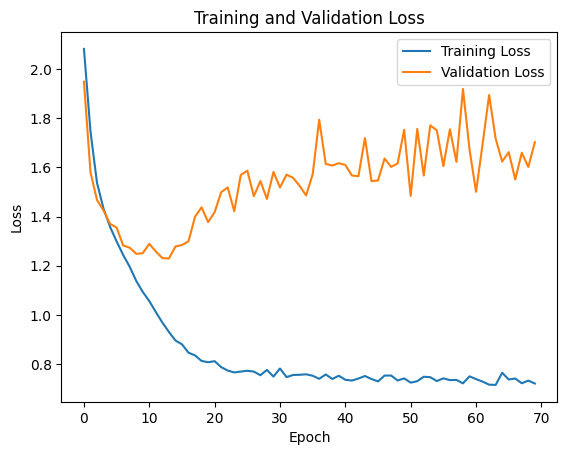

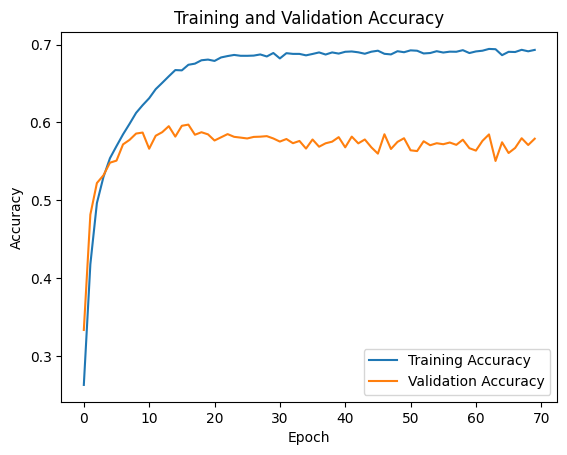

Test Accuracy for MiniVGG_v2 model: 0.5763


In [13]:
# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Test the model
test_accuracy = test(model, test_loader)
print(f"Test Accuracy for MiniVGG_v2 model: {test_accuracy:.4f}")

###  Batch Normalization

In [40]:
class MiniVGG_with_global_avg_pool_BN(nn.Module):
    def __init__(self):
        super(MiniVGG_with_global_avg_pool_BN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)  # Batch normalization after conv1
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization after conv2
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization after conv3
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)  # Batch normalization after conv4
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)  # Batch normalization after conv5
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)  # Batch normalization after conv6
        self.maxpool3 = nn.MaxPool2d(2, 2)
        self.conv7 = nn.Conv2d(256, 128, 1)  # Add convolution layer (1x1) x 128
        self.bn7 = nn.BatchNorm2d(128)  # Batch normalization after conv7
        self.conv8 = nn.Conv2d(128, 10, 1)   # Add convolution layer (1x1) x 10
        self.bn8 = nn.BatchNorm2d(10)  # Batch normalization after conv8

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.maxpool1(x)
        x = torch.relu(self.bn3(self.conv3(x)))
        x = torch.relu(self.bn4(self.conv4(x)))
        x = self.maxpool2(x)
        x = torch.relu(self.bn5(self.conv5(x)))
        x = torch.relu(self.bn6(self.conv6(x)))
        x = self.maxpool3(x)
        x = torch.relu(self.bn7(self.conv7(x)))  # Apply convolution (1x1) x 128 with batch normalization
        x = torch.relu(self.bn8(self.conv8(x)))  # Apply convolution (1x1) x 10 with batch normalization
        x = torch.nn.functional.avg_pool2d(x, x.size()[2:])  # Global Average Pooling using avg_pool2d from torch.nn.functional
        x = x.view(-1, 10)  # Reshape to (batch_size, num_classes)
        return x

### Data Augmentation

In [41]:
# Define data augmentation and normalization transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_val_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 datasets with transformations
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val_test)
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val_test)

# Define data loaders
# Move train and validation data loaders to GPU
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

# Display the number of samples in the training, validation, and testing sets
print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))
print("Number of testing samples:", len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 50000
Number of validation samples: 10000
Number of testing samples: 10000


In [16]:
# Initialize MiniVGG model with Batch Normalization
model_with_global_avg_pool_BN = MiniVGG_with_global_avg_pool_BN().to(device)

# Define criterion, optimizer, and learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_with_global_avg_pool_BN.parameters(), lr=0.001)

# Train MiniVGG model with Batch Normalization
train_losses_bn, val_losses_bn, train_accs_bn, val_accs_bn = train(model_with_global_avg_pool_BN, criterion, optimizer, train_loader, val_loader)

Epoch 1/100, Train Loss: 1.5300, Val Loss: 1.1703, Train Acc: 0.5031, Val Acc: 0.6321, Time: 8.09 seconds
Epoch 2/100, Train Loss: 1.1032, Val Loss: 0.8943, Train Acc: 0.6568, Val Acc: 0.7153, Time: 7.82 seconds
Epoch 3/100, Train Loss: 0.9051, Val Loss: 0.8096, Train Acc: 0.7169, Val Acc: 0.7357, Time: 7.91 seconds
Epoch 4/100, Train Loss: 0.7816, Val Loss: 0.7035, Train Acc: 0.7531, Val Acc: 0.7819, Time: 7.85 seconds
Epoch 5/100, Train Loss: 0.6978, Val Loss: 0.6125, Train Acc: 0.7782, Val Acc: 0.8052, Time: 7.84 seconds
Epoch 6/100, Train Loss: 0.6400, Val Loss: 0.5825, Train Acc: 0.7951, Val Acc: 0.8122, Time: 7.85 seconds
Epoch 7/100, Train Loss: 0.5894, Val Loss: 0.5718, Train Acc: 0.8098, Val Acc: 0.8134, Time: 7.82 seconds
Epoch 8/100, Train Loss: 0.5470, Val Loss: 0.5344, Train Acc: 0.8242, Val Acc: 0.8254, Time: 7.82 seconds
Epoch 9/100, Train Loss: 0.5122, Val Loss: 0.5402, Train Acc: 0.8327, Val Acc: 0.8183, Time: 7.86 seconds
Epoch 10/100, Train Loss: 0.4851, Val Loss: 0.

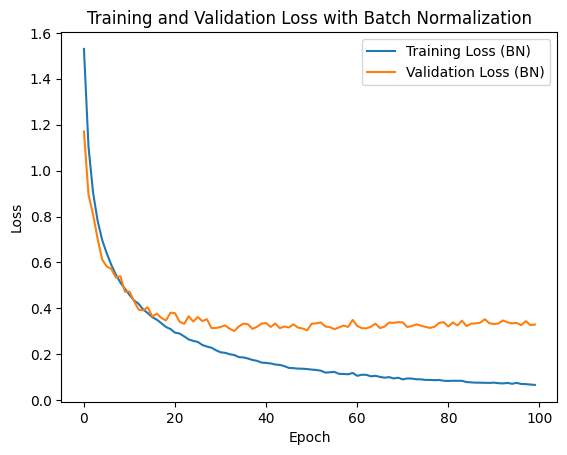

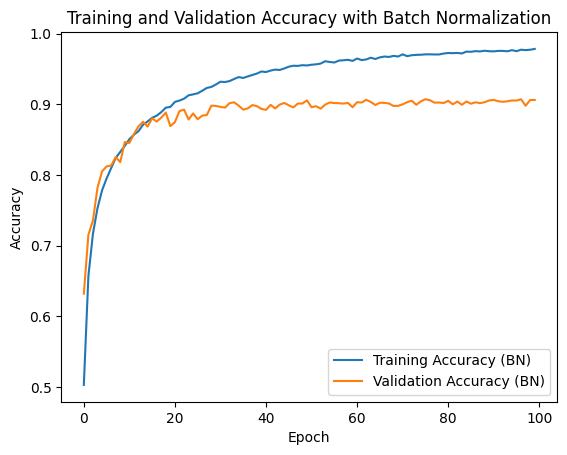

Test Accuracy for MiniVGG_with_global_avg_pool model with Batch Normalization: 0.9062


In [17]:
# Plot training and validation loss with Batch Normalization
plt.plot(train_losses_bn, label='Training Loss (BN)')
plt.plot(val_losses_bn, label='Validation Loss (BN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with Batch Normalization')
plt.legend()
plt.show()

# Plot training and validation accuracy with Batch Normalization
plt.plot(train_accs_bn, label='Training Accuracy (BN)')
plt.plot(val_accs_bn, label='Validation Accuracy (BN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy with Batch Normalization')
plt.legend()
plt.show()

# Test the model with Batch Normalization
test_accuracy_bn = test(model_with_global_avg_pool_BN, test_loader)
print(f"Test Accuracy for MiniVGG_with_global_avg_pool model with Batch Normalization: {test_accuracy_bn:.4f}")

### RMSProp Optimizer and L2 Regularization with weight decay of 1e-4

In [18]:
# Initialize MiniVGG model with Batch Normalization
model_with_global_avg_pool_BN = MiniVGG_with_global_avg_pool_BN().to(device)

# Define criterion
criterion = nn.CrossEntropyLoss()

# Define optimizer with L2 regularization
optimizer = torch.optim.RMSprop(model_with_global_avg_pool_BN.parameters(), lr=0.0001, weight_decay=1e-4)

# Train MiniVGG model with Batch Normalization
train_losses_bn, val_losses_bn, train_accs_bn, val_accs_bn = train(model_with_global_avg_pool_BN, criterion, optimizer, train_loader, val_loader,  num_epochs=130)

Epoch 1/130, Train Loss: 1.6177, Val Loss: 1.4200, Train Acc: 0.4953, Val Acc: 0.5707, Time: 7.48 seconds
Epoch 2/130, Train Loss: 1.3746, Val Loss: 1.2645, Train Acc: 0.6061, Val Acc: 0.6196, Time: 7.47 seconds
Epoch 3/130, Train Loss: 1.2602, Val Loss: 1.1994, Train Acc: 0.6537, Val Acc: 0.6617, Time: 7.46 seconds
Epoch 4/130, Train Loss: 1.1729, Val Loss: 1.1249, Train Acc: 0.6845, Val Acc: 0.6751, Time: 7.51 seconds
Epoch 5/130, Train Loss: 1.0996, Val Loss: 1.0326, Train Acc: 0.7083, Val Acc: 0.7175, Time: 7.45 seconds
Epoch 6/130, Train Loss: 1.0370, Val Loss: 0.9900, Train Acc: 0.7298, Val Acc: 0.7309, Time: 7.46 seconds
Epoch 7/130, Train Loss: 0.9902, Val Loss: 0.9335, Train Acc: 0.7411, Val Acc: 0.7413, Time: 7.48 seconds
Epoch 8/130, Train Loss: 0.9402, Val Loss: 0.8743, Train Acc: 0.7568, Val Acc: 0.7615, Time: 7.44 seconds
Epoch 9/130, Train Loss: 0.8974, Val Loss: 0.9210, Train Acc: 0.7663, Val Acc: 0.7318, Time: 7.47 seconds
Epoch 10/130, Train Loss: 0.8574, Val Loss: 0.

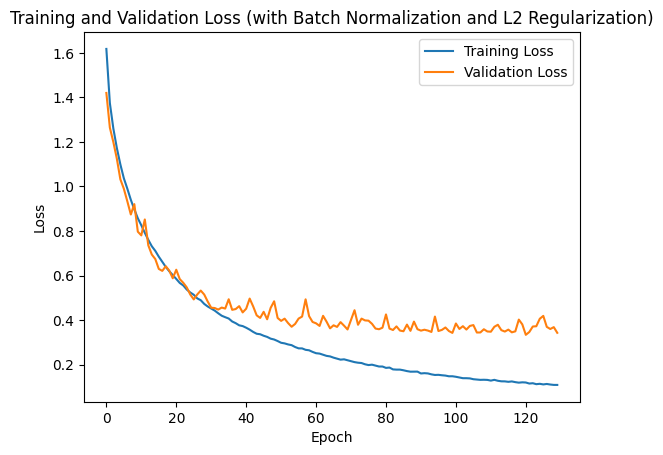

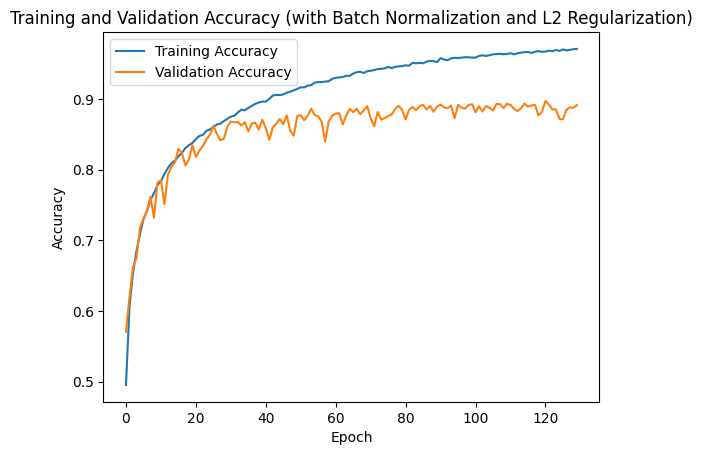

Test Accuracy for MiniVGG_with_global_avg_pool_BN model (with Batch Normalization and L2 Regularization): 0.8914


In [19]:
# Plotting training and validation loss
plt.plot(train_losses_bn, label='Training Loss')
plt.plot(val_losses_bn, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (with Batch Normalization and L2 Regularization)')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(train_accs_bn, label='Training Accuracy')
plt.plot(val_accs_bn, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (with Batch Normalization and L2 Regularization)')
plt.legend()
plt.show()

# Test the model
test_accuracy_bn = test(model_with_global_avg_pool_BN, test_loader)
print(f"Test Accuracy for MiniVGG_with_global_avg_pool_BN model (with Batch Normalization and L2 Regularization): {test_accuracy_bn:.4f}")

### Trying the same with Adam Optimizer (along with L2 Regularization with weight decay of 1e-3)

In [42]:
# Initialize MiniVGG model with Batch Normalization
model_with_global_avg_pool_BN = MiniVGG_with_global_avg_pool_BN().to(device)

# Define criterion
criterion = nn.CrossEntropyLoss()

# Define optimizer with L2 regularization
optimizer = torch.optim.Adam(model_with_global_avg_pool_BN.parameters(), lr=0.0001, weight_decay=1e-3)

# Train MiniVGG model with Batch Normalization
train_losses_bn, val_losses_bn, train_accs_bn, val_accs_bn = train(model_with_global_avg_pool_BN, criterion, optimizer, train_loader, val_loader,  num_epochs=200)

Epoch 1/200, Train Loss: 1.6932, Val Loss: 1.4330, Train Acc: 0.4635, Val Acc: 0.5600, Time: 8.05 seconds
Epoch 2/200, Train Loss: 1.4234, Val Loss: 1.2922, Train Acc: 0.5880, Val Acc: 0.6328, Time: 7.89 seconds
Epoch 3/200, Train Loss: 1.2956, Val Loss: 1.1730, Train Acc: 0.6401, Val Acc: 0.6742, Time: 7.82 seconds
Epoch 4/200, Train Loss: 1.1939, Val Loss: 1.0668, Train Acc: 0.6763, Val Acc: 0.7076, Time: 7.84 seconds
Epoch 5/200, Train Loss: 1.1196, Val Loss: 1.0079, Train Acc: 0.6985, Val Acc: 0.7340, Time: 7.87 seconds
Epoch 6/200, Train Loss: 1.0541, Val Loss: 0.9449, Train Acc: 0.7214, Val Acc: 0.7416, Time: 8.02 seconds
Epoch 7/200, Train Loss: 0.9980, Val Loss: 0.8931, Train Acc: 0.7362, Val Acc: 0.7561, Time: 7.86 seconds
Epoch 8/200, Train Loss: 0.9508, Val Loss: 0.8368, Train Acc: 0.7513, Val Acc: 0.7729, Time: 7.82 seconds
Epoch 9/200, Train Loss: 0.9047, Val Loss: 0.8336, Train Acc: 0.7651, Val Acc: 0.7765, Time: 7.79 seconds
Epoch 10/200, Train Loss: 0.8640, Val Loss: 0.

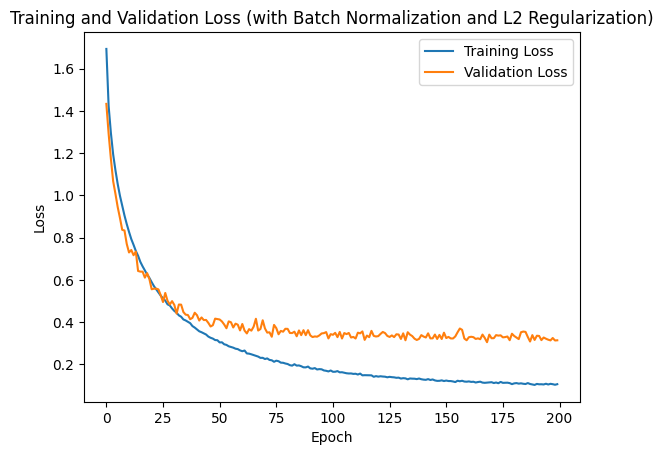

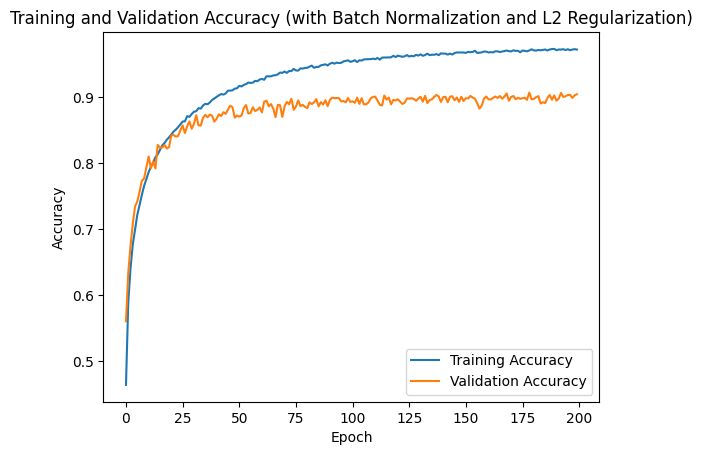

Test Accuracy for MiniVGG_with_global_avg_pool_BN model (with Batch Normalization and L2 Regularization): 0.9040


In [43]:
# Plotting training and validation loss
plt.plot(train_losses_bn, label='Training Loss')
plt.plot(val_losses_bn, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (with Batch Normalization and L2 Regularization)')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(train_accs_bn, label='Training Accuracy')
plt.plot(val_accs_bn, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (with Batch Normalization and L2 Regularization)')
plt.legend()
plt.show()

# Test the model
test_accuracy_bn = test(model_with_global_avg_pool_BN, test_loader)
print(f"Test Accuracy for MiniVGG_with_global_avg_pool_BN model (with Batch Normalization and L2 Regularization): {test_accuracy_bn:.4f}")

### Adding dropout with probability of 0.1 - DELETE IT IF THE GRAPH IS BAD

In [80]:
import torch
import torch.nn as nn

class MiniVGG_with_global_avg_pool_BN_dropout(nn.Module):
    def __init__(self, dropout_prob=0.05):
        super(MiniVGG_with_global_avg_pool_BN_dropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)  # Batch normalization after conv1
        self.dropout1 = nn.Dropout(dropout_prob)  # Dropout after conv1
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization after conv2
        self.dropout2 = nn.Dropout(dropout_prob)  # Dropout after conv2
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization after conv3
        self.dropout3 = nn.Dropout(dropout_prob)  # Dropout after conv3
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)  # Batch normalization after conv4
        self.dropout4 = nn.Dropout(dropout_prob)  # Dropout after conv4
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)  # Batch normalization after conv5
        self.dropout5 = nn.Dropout(dropout_prob)  # Dropout after conv5
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)  # Batch normalization after conv6
        self.dropout6 = nn.Dropout(dropout_prob)  # Dropout after conv6
        self.maxpool3 = nn.MaxPool2d(2, 2)
        self.conv7 = nn.Conv2d(256, 128, 1)  # Add convolution layer (1x1) x 128
        self.bn7 = nn.BatchNorm2d(128)  # Batch normalization after conv7
        self.dropout7 = nn.Dropout(dropout_prob)  # Dropout after conv7
        self.conv8 = nn.Conv2d(128, 10, 1)   # Add convolution layer (1x1) x 10
        self.bn8 = nn.BatchNorm2d(10)  # Batch normalization after conv8
        self.dropout8 = nn.Dropout(dropout_prob)  # Dropout after conv8

    def forward(self, x):
        x = torch.relu(self.dropout1(self.bn1(self.conv1(x))))
        x = torch.relu(self.dropout2(self.bn2(self.conv2(x))))
        x = self.maxpool1(x)
        x = torch.relu(self.dropout3(self.bn3(self.conv3(x))))
        x = torch.relu(self.dropout4(self.bn4(self.conv4(x))))
        x = self.maxpool2(x)
        x = torch.relu(self.dropout5(self.bn5(self.conv5(x))))
        x = torch.relu(self.dropout6(self.bn6(self.conv6(x))))
        x = self.maxpool3(x)
        x = torch.relu(self.dropout7(self.bn7(self.conv7(x))))  # Apply convolution (1x1) x 128 with batch normalization
        x = torch.relu(self.dropout8(self.bn8(self.conv8(x))))  # Apply convolution (1x1) x 10 with batch normalization
        x = torch.nn.functional.avg_pool2d(x, x.size()[2:])  # Global Average Pooling using avg_pool2d from torch.nn.functional
        x = x.view(-1, 10)  # Reshape to (batch_size, num_classes)
        return x


In [81]:
# Initialize MiniVGG model with Batch Normalization
model_with_global_avg_pool_BN = MiniVGG_with_global_avg_pool_BN_dropout().to(device)

# Define criterion
criterion = nn.CrossEntropyLoss()

# Define optimizer with L2 regularization
optimizer = torch.optim.Adam(model_with_global_avg_pool_BN.parameters(), lr=0.0001, weight_decay=1e-3)

# Train MiniVGG model with Batch Normalization
train_losses_bn, val_losses_bn, train_accs_bn, val_accs_bn = train(model_with_global_avg_pool_BN, criterion, optimizer, train_loader, val_loader,  num_epochs=200)

Epoch 1/200, Train Loss: 1.7478, Val Loss: 1.5423, Train Acc: 0.4345, Val Acc: 0.5193, Time: 7.94 seconds
Epoch 2/200, Train Loss: 1.4827, Val Loss: 1.4173, Train Acc: 0.5573, Val Acc: 0.5791, Time: 7.81 seconds
Epoch 3/200, Train Loss: 1.3484, Val Loss: 1.3009, Train Acc: 0.6151, Val Acc: 0.6266, Time: 7.83 seconds
Epoch 4/200, Train Loss: 1.2523, Val Loss: 1.2068, Train Acc: 0.6486, Val Acc: 0.6596, Time: 7.84 seconds
Epoch 5/200, Train Loss: 1.1755, Val Loss: 1.1104, Train Acc: 0.6738, Val Acc: 0.6797, Time: 7.87 seconds
Epoch 6/200, Train Loss: 1.1104, Val Loss: 1.0948, Train Acc: 0.6972, Val Acc: 0.6817, Time: 7.91 seconds
Epoch 7/200, Train Loss: 1.0525, Val Loss: 1.0457, Train Acc: 0.7159, Val Acc: 0.6932, Time: 7.91 seconds
Epoch 8/200, Train Loss: 1.0026, Val Loss: 0.8909, Train Acc: 0.7312, Val Acc: 0.7636, Time: 7.95 seconds
Epoch 9/200, Train Loss: 0.9548, Val Loss: 0.8611, Train Acc: 0.7450, Val Acc: 0.7763, Time: 7.83 seconds
Epoch 10/200, Train Loss: 0.9161, Val Loss: 0.

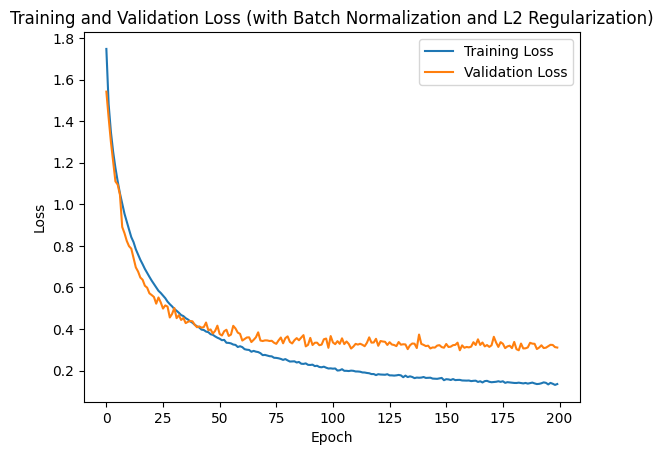

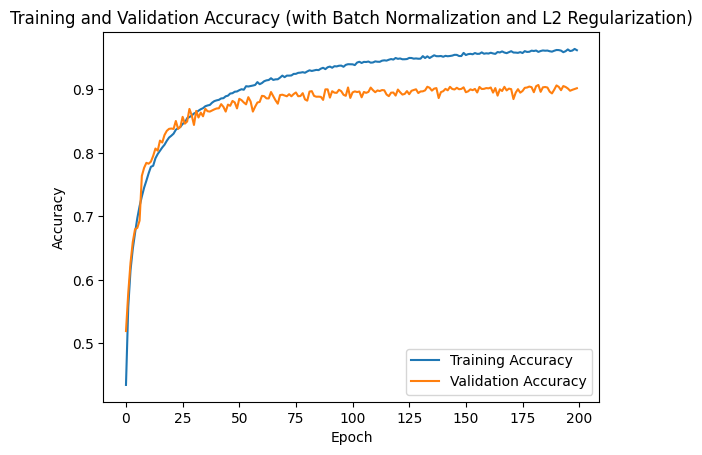

Test Accuracy for MiniVGG_with_global_avg_pool_BN model (with Batch Normalization and L2 Regularization): 0.9017


In [82]:
# Plotting training and validation loss
plt.plot(train_losses_bn, label='Training Loss')
plt.plot(val_losses_bn, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (with Batch Normalization and L2 Regularization)')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(train_accs_bn, label='Training Accuracy')
plt.plot(val_accs_bn, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (with Batch Normalization and L2 Regularization)')
plt.legend()
plt.show()

# Test the model
test_accuracy_bn = test(model_with_global_avg_pool_BN, test_loader)
print(f"Test Accuracy for MiniVGG_with_global_avg_pool_BN model (with Batch Normalization and L2 Regularization): {test_accuracy_bn:.4f}")

____

______

_______

# ****** BELOW CODE IS NOT REQUIRED (IT IS FOR TESTING/PRACTICE PURPOSE) ******

### Trying the same with Adam Optimizer (along with L2 Regularization with weight decay of 5e-4) - Almost similar to the above graph but above graph is better

In [80]:
# Initialize MiniVGG model with Batch Normalization
model_with_global_avg_pool_BN = MiniVGG_with_global_avg_pool_BN().to(device)

# Define criterion
criterion = nn.CrossEntropyLoss()

# Define optimizer with L2 regularization
optimizer = torch.optim.Adam(model_with_global_avg_pool_BN.parameters(), lr=0.0001, weight_decay=5e-4)

# Train MiniVGG model with Batch Normalization
train_losses_bn, val_losses_bn, train_accs_bn, val_accs_bn = train(model_with_global_avg_pool_BN, criterion, optimizer, train_loader, val_loader,  num_epochs=170)

Epoch 1/170, Train Loss: 1.7073, Val Loss: 1.4733, Train Acc: 0.4562, Val Acc: 0.5496, Time: 7.99 seconds
Epoch 2/170, Train Loss: 1.4349, Val Loss: 1.3119, Train Acc: 0.5832, Val Acc: 0.6178, Time: 7.94 seconds
Epoch 3/170, Train Loss: 1.3027, Val Loss: 1.2210, Train Acc: 0.6364, Val Acc: 0.6307, Time: 7.88 seconds
Epoch 4/170, Train Loss: 1.2079, Val Loss: 1.1250, Train Acc: 0.6671, Val Acc: 0.6798, Time: 7.89 seconds
Epoch 5/170, Train Loss: 1.1275, Val Loss: 1.0456, Train Acc: 0.6963, Val Acc: 0.7087, Time: 7.95 seconds
Epoch 6/170, Train Loss: 1.0668, Val Loss: 1.0210, Train Acc: 0.7141, Val Acc: 0.7154, Time: 7.83 seconds
Epoch 7/170, Train Loss: 1.0081, Val Loss: 0.9074, Train Acc: 0.7342, Val Acc: 0.7590, Time: 7.88 seconds
Epoch 8/170, Train Loss: 0.9590, Val Loss: 0.8458, Train Acc: 0.7480, Val Acc: 0.7724, Time: 7.91 seconds
Epoch 9/170, Train Loss: 0.9147, Val Loss: 0.8649, Train Acc: 0.7592, Val Acc: 0.7652, Time: 7.88 seconds
Epoch 10/170, Train Loss: 0.8751, Val Loss: 0.

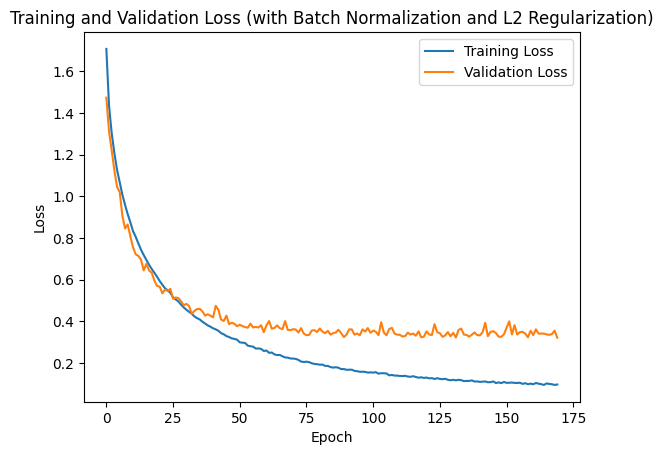

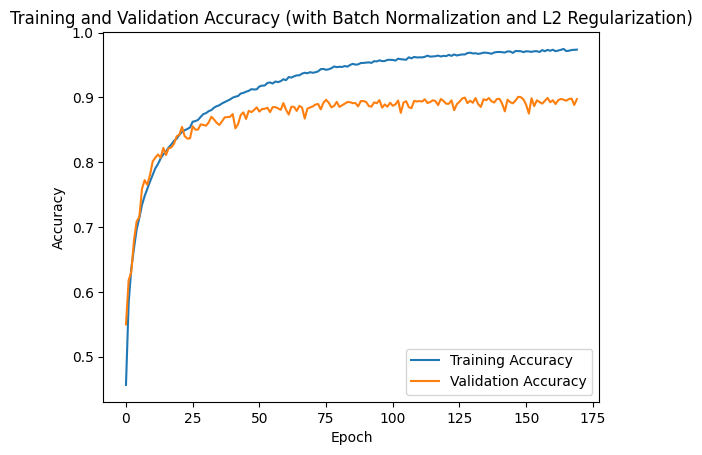

Test Accuracy for MiniVGG_with_global_avg_pool_BN model (with Batch Normalization and L2 Regularization): 0.8974


In [81]:
# Plotting training and validation loss
plt.plot(train_losses_bn, label='Training Loss')
plt.plot(val_losses_bn, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (with Batch Normalization and L2 Regularization)')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(train_accs_bn, label='Training Accuracy')
plt.plot(val_accs_bn, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (with Batch Normalization and L2 Regularization)')
plt.legend()
plt.show()

# Test the model
test_accuracy_bn = test(model_with_global_avg_pool_BN, test_loader)
print(f"Test Accuracy for MiniVGG_with_global_avg_pool_BN model (with Batch Normalization and L2 Regularization): {test_accuracy_bn:.4f}")

### Trying the same with Adam Optimizer (along with L2 Regularization with weight decay of 1e-2) 
### Changing learning rate to 0.00001

In [89]:
# # Initialize MiniVGG model with Batch Normalization
# model_with_global_avg_pool_BN = MiniVGG_with_global_avg_pool_BN().to(device)

# # Define criterion
# criterion = nn.CrossEntropyLoss()

# # Define optimizer with L2 regularization
# optimizer = torch.optim.Adam(model_with_global_avg_pool_BN.parameters(), lr=0.00001, weight_decay=1e-2)

# # Train MiniVGG model with Batch Normalization
# train_losses_bn, val_losses_bn, train_accs_bn, val_accs_bn = train(model_with_global_avg_pool_BN, criterion, optimizer, train_loader, val_loader,  num_epochs=70)

In [90]:
# # Plotting training and validation loss
# plt.plot(train_losses_bn, label='Training Loss')
# plt.plot(val_losses_bn, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss (with Batch Normalization and L2 Regularization)')
# plt.legend()
# plt.show()

# # Plotting training and validation accuracy
# plt.plot(train_accs_bn, label='Training Accuracy')
# plt.plot(val_accs_bn, label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Training and Validation Accuracy (with Batch Normalization and L2 Regularization)')
# plt.legend()
# plt.show()

# # Test the model
# test_accuracy_bn = test(model_with_global_avg_pool_BN, test_loader)
# print(f"Test Accuracy for MiniVGG_with_global_avg_pool_BN model (with Batch Normalization and L2 Regularization): {test_accuracy_bn:.4f}")

### Adding Droput with a probability of 0.1

In [91]:
# class MiniVGG_with_global_avg_pool_BN_dropout(nn.Module):
#     def __init__(self):
#         super(MiniVGG_with_global_avg_pool_BN_dropout, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
#         self.bn1 = nn.BatchNorm2d(64)  # Batch normalization after conv1
#         self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
#         self.bn2 = nn.BatchNorm2d(64)  # Batch normalization after conv2
#         self.maxpool1 = nn.MaxPool2d(2, 2)
#         self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
#         self.bn3 = nn.BatchNorm2d(128)  # Batch normalization after conv3
#         self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
#         self.bn4 = nn.BatchNorm2d(128)  # Batch normalization after conv4
#         self.maxpool2 = nn.MaxPool2d(2, 2)
#         self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
#         self.bn5 = nn.BatchNorm2d(256)  # Batch normalization after conv5
#         self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
#         self.bn6 = nn.BatchNorm2d(256)  # Batch normalization after conv6
#         self.maxpool3 = nn.MaxPool2d(2, 2)
#         self.conv7 = nn.Conv2d(256, 128, 1)  # Add convolution layer (1x1) x 128
#         self.bn7 = nn.BatchNorm2d(128)  # Batch normalization after conv7
#         self.conv8 = nn.Conv2d(128, 10, 1)   # Add convolution layer (1x1) x 10
#         self.bn8 = nn.BatchNorm2d(10)  # Batch normalization after conv8
#         self.dropout = nn.Dropout(p=0.35)  # Dropout layer with probability 0.5

#     def forward(self, x):
#         x = torch.relu(self.bn1(self.conv1(x)))
#         x = torch.relu(self.bn2(self.conv2(x)))
#         x = self.maxpool1(x)
#         x = torch.relu(self.bn3(self.conv3(x)))
#         x = torch.relu(self.bn4(self.conv4(x)))
#         x = self.maxpool2(x)
#         x = torch.relu(self.bn5(self.conv5(x)))
#         x = torch.relu(self.bn6(self.conv6(x)))
#         x = self.maxpool3(x)
#         x = torch.relu(self.bn7(self.conv7(x)))  # Apply convolution (1x1) x 128 with batch normalization
#         x = torch.relu(self.bn8(self.conv8(x)))  # Apply convolution (1x1) x 10 with batch normalization
#         x = torch.nn.functional.avg_pool2d(x, x.size()[2:])  # Global Average Pooling using avg_pool2d from torch.nn.functional
#         x = x.view(-1, 10)  # Reshape to (batch_size, num_classes)
#         x = self.dropout(x)  # Apply dropout to the last layer
#         return x

In [65]:
# # Initialize MiniVGG model with Batch Normalization and Dropout
# model_with_global_avg_pool_BN_dropout = MiniVGG_with_global_avg_pool_BN_dropout().to(device)

# # Set dropout probability
# dropout_probability = 0.35
# model_with_global_avg_pool_BN_dropout.dropout.p = dropout_probability

# # Define criterion, optimizer, and learning rate with weight decay
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model_with_global_avg_pool_BN.parameters(), lr=0.0001, weight_decay=1e-3)

# # Train MiniVGG model with Batch Normalization and Dropout with increased epochs
# train_losses_bn, val_losses_bn, train_accs_bn, val_accs_bn = train(model_with_global_avg_pool_BN_dropout, criterion, optimizer, train_loader, val_loader, num_epochs=70)

In [ ]:
# # Plotting training and validation loss
# plt.plot(train_losses_bn, label='Training Loss')
# plt.plot(val_losses_bn, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss (with Batch Normalization, Dropout, and L2 Regularization)')
# plt.legend()
# plt.show()

# # Plotting training and validation accuracy
# plt.plot(train_accs_bn, label='Training Accuracy')
# plt.plot(val_accs_bn, label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Training and Validation Accuracy (with Batch Normalization, Dropout, and L2 Regularization)')
# plt.legend()
# plt.show()

# # Calculate and print test accuracy
# test_accuracy_bn_dropout = test(model_with_global_avg_pool_BN_dropout, test_loader)
# print(f"Test Accuracy for MiniVGG_with_global_avg_pool_BN_dropout model (with Batch Normalization, Dropout, and L2 Regularization): {test_accuracy_bn_dropout:.4f}")